# The effects of Brexit

The aim of this notebook is to estimate the causal impact of Brexit upon the UK's GDP. This will be done using the synthetic control approch. As such, it is similar to the policy brief ["What can we know about the cost of Brexit so far?"](https://www.cer.eu/publications/archive/policy-brief/2022/cost-brexit-so-far) by John Springford from the Center for European Reform. That approach did not use Bayesian estimation methods however.

I did not use the GDP data from the above report however as it had been scaled in some way that was hard for me to understand how it related to the absolute GDP figures. Instead, GDP data was obtained courtesy of Prof. Dooruj Rambaccussing. Raw data is in units of billions of USD.

<div class="alert alert-warning">

Warning

This is an experimental and in-progress notebook! While the results are reasonable, there is still come perfecting to be done on the inference side of things. There are high correlations between countries, and the prior for the Dirichlet distribution for country weightings could do with some attention. That said, the results here represent a 'reasonable' first approach at this dataset.

</div>

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import causalpy as cp

In [2]:
%load_ext autoreload
%autoreload 2
# %config InlineBackend.figure_format = 'retina'
# %config InlineBackend.figure_format = 'svg'

## Load data

In [3]:
df = cp.load_data("brexit")

df["Time"] = pd.to_datetime(df["Time"])
df.set_index("Time", inplace=True)
df = df.iloc[df.index > "2009", :]

# specify date of the Brexit vote announcement
treatment_time = pd.to_datetime("2016 June 24")

In [4]:
# manual exclusion of some countries
df = df.drop(["Japan", "Italy", "US", "Spain"], axis=1)

In [5]:
# get useful country lists
target_country = "UK"
all_countries = df.columns
other_countries = all_countries.difference({target_country})
all_countries = list(all_countries)
other_countries = list(other_countries)

## Data visualization

In [6]:
az.style.use("arviz-white")

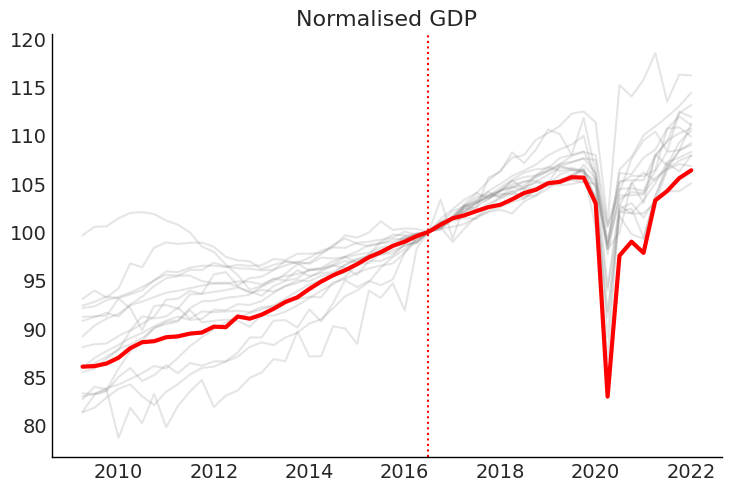

In [7]:
# Plot the time series normalised so that intervention point (Q3 2016) is equal to 100
gdp_at_intervention = df.loc[pd.to_datetime("2016 July 01"), :]
df_normalised = (df / gdp_at_intervention) * 100.0

# plot
fig, ax = plt.subplots()
for col in other_countries:
    ax.plot(df_normalised.index, df_normalised[col], color="grey", alpha=0.2)

ax.plot(df_normalised.index, df_normalised[target_country], color="red", lw=3)
# ax = df_normalised.plot(legend=False)

# formatting
ax.set(title="Normalised GDP")
ax.axvline(x=treatment_time, color="r", ls=":");

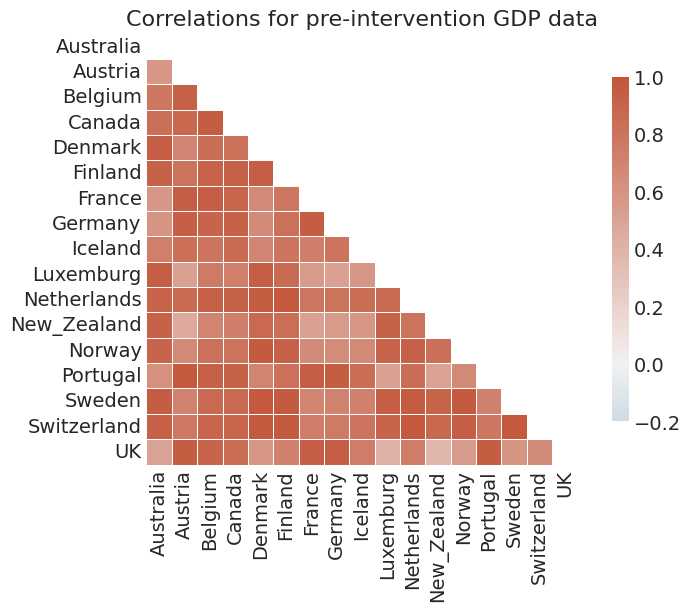

In [8]:
# Examine how correlated the pre-intervention time series are

pre_intervention_data = df.loc[df.index > treatment_time, :]

corr = pre_intervention_data.corr()

f, ax = plt.subplots(figsize=(8, 6))
ax = sns.heatmap(
    corr,
    mask=np.triu(np.ones_like(corr, dtype=bool)),
    cmap=sns.diverging_palette(230, 20, as_cmap=True),
    vmin=-0.2,
    vmax=1.0,
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8},
)
ax.set(title="Correlations for pre-intervention GDP data");

## Run the analysis

Note: The analysis is (and should be) run on the raw GDP data. We do not use the normalised data shown above which was just for ease of visualization.

In [9]:
# build a model formula
formula = target_country + " ~ " + "0 + " + " + ".join(other_countries)

print(formula)

UK ~ 0 + Australia + Austria + Belgium + Canada + Denmark + Finland + France + Germany + Iceland + Luxemburg + Netherlands + New_Zealand + Norway + Portugal + Sweden + Switzerland


In [10]:
sample_kwargs = {"tune": 4000, "target_accept": 0.99}

result = cp.pymc_experiments.SyntheticControl(
    df,
    treatment_time,
    formula=formula,
    prediction_model=cp.pymc_models.WeightedSumFitter(sample_kwargs=sample_kwargs),
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Sampling 4 chains for 4_000 tune and 1_000 draw iterations (16_000 + 4_000 draws total) took 383 seconds.
Sampling: [beta, sigma, y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]


We currently get some divergences, but these are mostly dealt with by increasing `tune` and `target_accept` sampling parameters. Nevertheless, the sampling of this dataset/model combination feels a little brittle.

Check the MCMC chain mixing via the `Rhat` statistic.

In [11]:
az.summary(result.idata, var_names=["~mu"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[Australia],0.123,0.074,0.000,0.246,0.002,0.002,692.0,494.0,1.00
beta[Austria],0.039,0.037,0.000,0.108,0.001,0.001,627.0,470.0,1.00
beta[Belgium],0.044,0.042,0.000,0.122,0.001,0.001,628.0,575.0,1.00
beta[Canada],0.041,0.023,0.000,0.079,0.001,0.001,620.0,503.0,1.01
beta[Denmark],0.076,0.057,0.000,0.177,0.002,0.001,672.0,685.0,1.00
beta[Finland],0.038,0.036,0.000,0.106,0.001,0.001,548.0,648.0,1.01
beta[France],0.030,0.027,0.000,0.081,0.001,0.001,879.0,577.0,1.01
beta[Germany],0.026,0.025,0.000,0.072,0.001,0.001,420.0,365.0,1.01
beta[Iceland],0.150,0.042,0.071,0.231,0.001,0.001,999.0,954.0,1.00
beta[Luxemburg],0.044,0.042,0.000,0.123,0.001,0.001,520.0,469.0,1.01


In [12]:
# Inspect the traces in more detail...
# az.plot_trace(result.idata, var_names="~mu", compact=False);

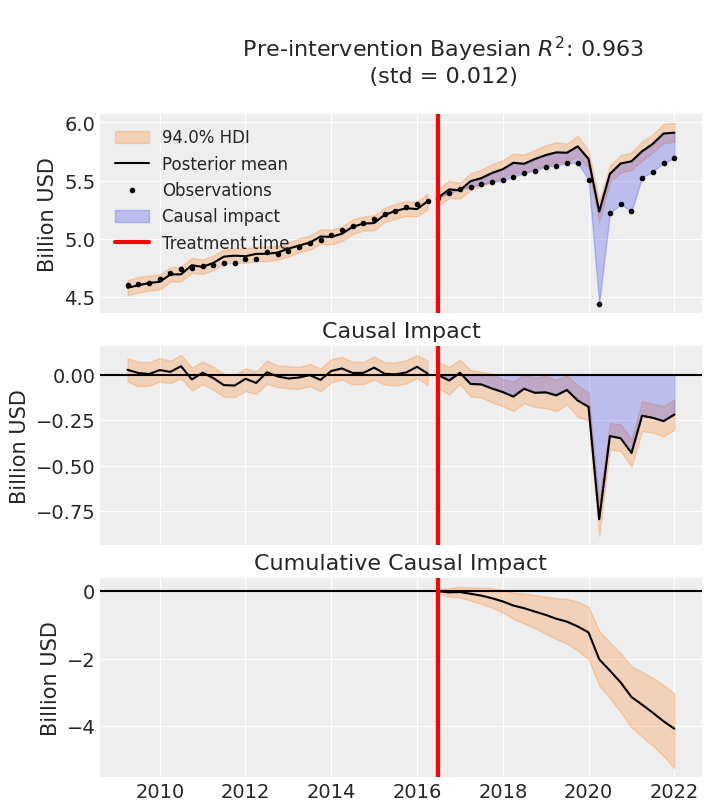

In [13]:
az.style.use("arviz-darkgrid")

fig, ax = result.plot(plot_predictors=False)

for i in [0, 1, 2]:
    ax[i].set(ylabel="Billion USD")

In [14]:
result.summary()

===============================Synthetic Control================================
Formula: UK ~ 0 + Australia + Austria + Belgium + Canada + Denmark + Finland + France + Germany + Iceland + Luxemburg + Netherlands + New_Zealand + Norway + Portugal + Sweden + Switzerland
Model coefficients:
Australia                     0.12, 94% HDI [0.01, 0.27]
Austria                       0.04, 94% HDI [0.00, 0.13]
Belgium                       0.04, 94% HDI [0.00, 0.15]
Canada                        0.04, 94% HDI [0.00, 0.09]
Denmark                       0.08, 94% HDI [0.00, 0.21]
Finland                       0.04, 94% HDI [0.00, 0.13]
France                        0.03, 94% HDI [0.00, 0.10]
Germany                       0.03, 94% HDI [0.00, 0.09]
Iceland                       0.15, 94% HDI [0.07, 0.23]
Luxemburg                     0.04, 94% HDI [0.00, 0.15]
Netherlands                   0.04, 94% HDI [0.00, 0.14]
New_Zealand                   0.06, 94% HDI [0.00, 0.18]
Norway                    

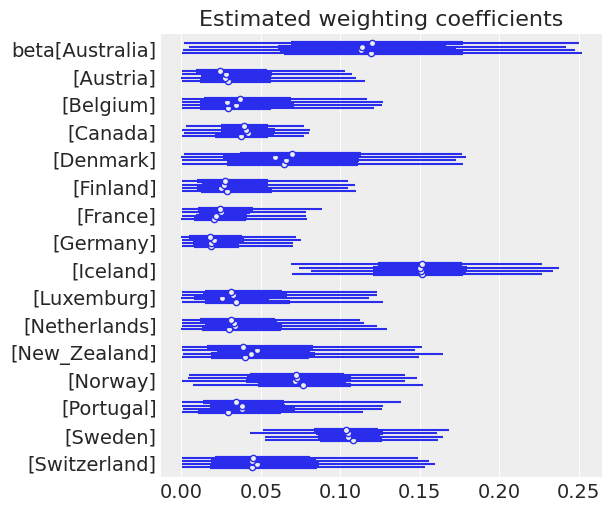

In [15]:
ax = az.plot_forest(result.idata, var_names="beta", figsize=(6, 5))
ax[0].set(title="Estimated weighting coefficients");